# Read and plot ensemble mean data (grid)
---
* This program is used for extracting and mapping ensemble mean data on grid from the subdirectory:
data/data/Future/EnsembleMean/Grids/

* The original souce of the data is:
http://lamps.math.yorku.ca/OntarioClimate/index_app_data.htm#/indexesEnsembleMeanGrids

* To reduce size of the data, we rewrote data as int16 in the github repository. Before use this data please read the 
 [AA_Readme.txt](https://github.com/ziwangdeng/ocdp.yorku.ca/blob/master/ocdpData/data/data/Future/EnsembleMean/Grids/AA_Readme.txt) 

* The data are annual values on 8964 grids in Ontario, for 45 variables from 1981-2099
* Since the matlab files were saved as v7.3 version, it needs h5py to read it

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
from geopandas import GeoSeries
# import scipy.io as sio
import datetime
import requests
import h5py

In [6]:
# user can select one of the variables in the next cell
varNames = ['CDD','Cold_day','Cold_night','DTR','FD','GSL','HDD','Hot_day','Hot_night','HWDI_days','HWDI_period',
            'HWDI_strength','ID','GS_StartDay','GS_EndDay','pr95pDays','pr95pTOT','pr99pDays','pr99pTOT','prCDD','PRCPTOT',
            'prCWD','R1mm','R5mm','R10mm','R20mm','R25mm','RX1day','RX5day','SDII','SU','tnCSDI','TNn','TNx',
            'TR','TXn','TXx','txWSDI','Tm','Tx','Tn','Pr', 'CHU','FFS','GDD']
# user can select one of the RCPs 
rcpNames =['RCP26', 'RCP45', 'RCP60', 'RCP85']  
print(np.size(varNames))

45


In [7]:
# user can change the variable name (select one from the varNames)
varName='CDD'
# user can change the RCP
rcp = 'RCP85' 

# the matfile_url is copied from the OCDP 
matfile_url = 'http://lamps.math.yorku.ca/OntarioClimate/data/content/grids/EnsembleMean/CDD_Ann_RCP26_8964PtsX119.mat'
# download the file to temp dirctory
totempfile = '../data/temp/tempfile.mat'
thefile = requests.get(matfile_url)
open(totempfile,'wb').write(thefile.content)

2857347

In [16]:
# read and map the variable for the period from 1981-2099
# datacontent=sio.loadmat()
f = h5py.File(totempfile,'r')
print(list(f.keys()))
x = f['data00']
data0 = np.array(x)
if varName == 'HDD' or varName =='CHU':
    data = data0/1.0   # the data in matfile is in integer format (convert to real value /1.0)
elif varName =='SDII':
    data = data0/100.0  # the data in matfile is integer format (vonvert to real value /100.0)
else:
    data = data0/10.0  # the data in matfile is integer format (convert to reall value /10.0)    
print(np.shape(data))

gridID= np.arange(1,8965)
cols = [str(i) for i in np.arange(1981,2100)]
print(np.shape(cols))
theDATA = pd.DataFrame(np.reshape(gridID,(8964,1)),columns=['id'])
theDATA[cols] = pd.DataFrame(data.transpose())

print(theDATA.head(1))

['data00']
(119, 8964)
(119,)
   id  1981  1982  1983      1984  1985  1986  1987      1988  1989  ...  \
0   1   0.0   0.0   0.0  0.019048   0.0   0.0   0.0  0.004762   0.0  ...   

      2090      2091      2092      2093      2094      2095      2096  \
0  0.12381  0.052381  0.033333  0.114286  0.114286  0.066667  0.047619   

       2097     2098      2099  
0  0.109524  0.07619  0.061905  

[1 rows x 120 columns]


In [17]:
# if you want to save the data to a csvfile, just change the path
csvfn = '../data/temp/mycsvfile.csv'
theDATA.to_csv(csvfn, index = False)

In [18]:
# We simplified the base four maps and saved them as geojson format, user can use other version base maps
# read basemap data in geojson files
lakefile='../shapefiles/Lake_Arc_simplify.geojson'
Municipal = '../shapefiles/Municipal_Arc_simplify.geojson'
Ontario = '../shapefiles/Ontario_arc.geojson'
OnPolygon = '../shapefiles/polygon9864.geojson'

# Ontario boundary
ont=gpd.read_file(Ontario)

# the lakes within Ontario
lake=gpd.read_file(lakefile)

# municipals
muni=gpd.read_file(Municipal)

# merge grid polygon and the data for plotting spatial variation map
cmp='jet'
poly=gpd.read_file(OnPolygon)
polydata = poly.merge(theDATA, on='id')

C:\Users\ldxd\Anaconda3\lib\site-packages\geopandas\plotting.py:385: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


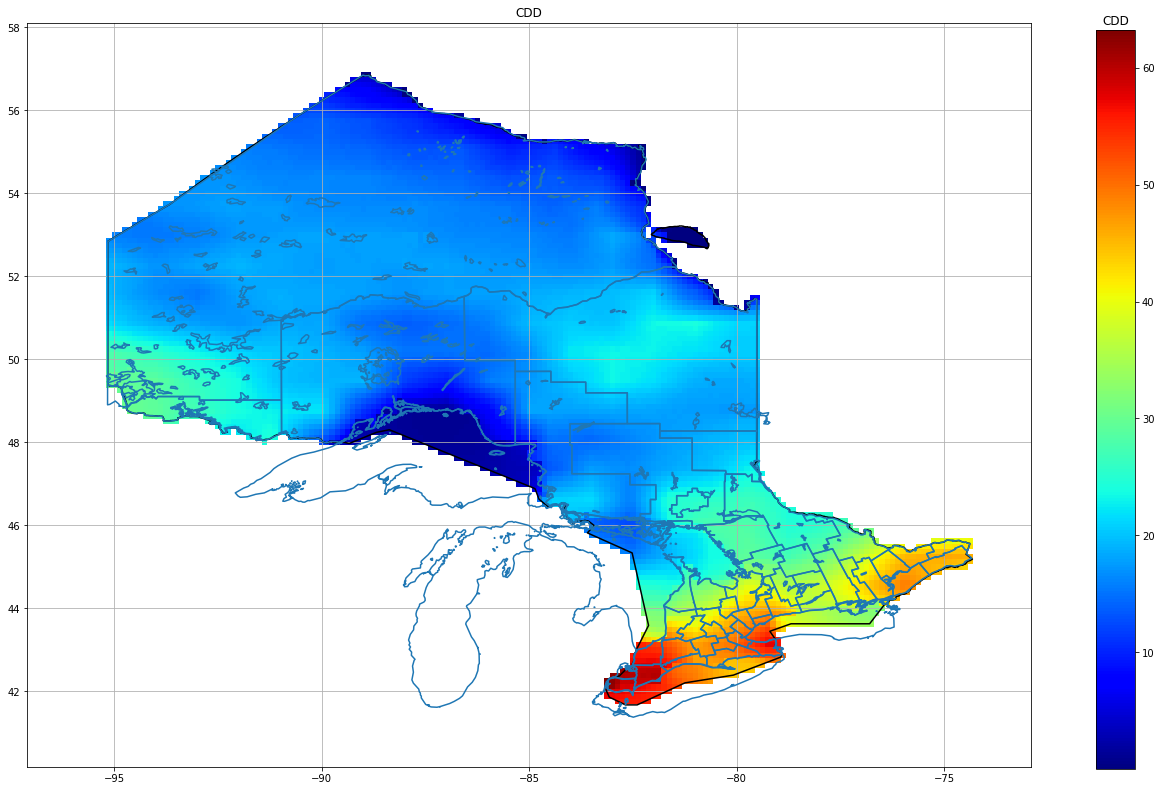

In [19]:
# display annual data values on a map
# use can change this year to display map for a specific year
Year = 2050 # 1981-2099



colnm =str(Year)
# plot the background
p1=Polygon([(-96,41),(-74,41),(-74,57.3),(-96,57.3)])
g = GeoSeries(p1)
base=g.plot(color='white', edgecolor='white', figsize=(18,27))
ont.plot(ax=base, color='black', edgecolor='black')

# plot maps
lake.plot(ax=base)
muni.plot(ax=base)
ax = polydata.plot(ax=base, column=colnm, colormap=cmp,vmin=min(polydata[colnm]),vmax=max(polydata[colnm]))

# setting legend
# thanks to: https://stackoverflow.com/questions/54236083/geopandas-reduce-legend-size-and-remove-white-space-below-map
ax.set_title(varName)
ax.grid() 
fig = ax.get_figure()
# here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)

cbax = fig.add_axes([0.95, 0.31, 0.03, 0.38])   
cbax.set_title(varName)

sm = plt.cm.ScalarMappable(cmap=cmp,norm=plt.Normalize(vmin=min(polydata[colnm]), vmax=max(polydata[colnm])))
sm._A = []
fig.colorbar(sm, cax=cbax, format="%d")
plt.show()



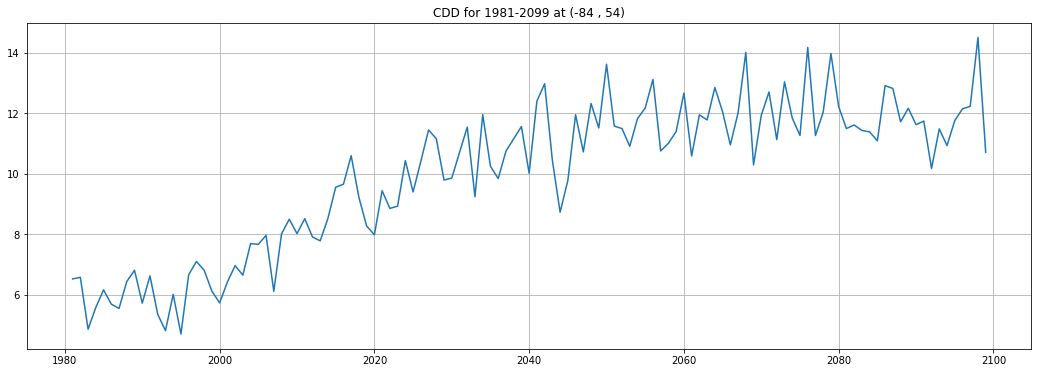

In [20]:
# following, we will plot time series at a specific location (latitude, longitude)
grids = pd.read_csv('../data/data/Historical/LAMPS_Ontario_8964Pts.csv')
# print(grids.columns)
lon=-84  # longitude in degree
lat=54   # latitude in degree
grids1=grids[abs(grids.Latitude-lat)<0.06251]
# print(grids1.columns)
grids2=grids1[abs(grids1.Longitude-lon)<0.06251]
if len(grids2) <1:
    print('sorry, your point is not in Ontario')
else:
    if len(grids2) ==1:
        timeseriesData= np.array(theDATA.iloc[grids2.ID-1,1:])
        # print(np.shape(timeseriesData))
    else:
        tmp=np.array(theDATA[grids2.ID,1:])
        print(np.shape(tmp))
        timeseriesData=np.mean(tmp,axis=0)
x = np.reshape(np.arange(1981,2100),(119,1))
y = np.reshape(timeseriesData,(119,1))
fig2 = plt.figure(figsize=(18,6))
ax=plt.subplot(1,1,1)
ax.grid()
plt.plot(x,y)
titletext=varName + ' for 1981-2099 at (' + str(lon) + ' , ' + str(lat) + ')'
ax.title.set_text(titletext)
# plt.show()